In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import calibration_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, roc_auc_score, log_loss, recall_score, f1_score

c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn import set_config
set_config(transform_output = 'pandas') # Retorna sempre um dataframe após transformação

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### Seleção de Features e Pré-processamento dos dados

Tanto o pre-processamento quanto a seleção de feature será feito sobre o conjunto de treinamento.

In [186]:
X_train = df_train.drop(['vitoria','ano_campeonato','rodada'] ,axis=1)
y_train = df_train['vitoria']

X_test = df_test.drop(['vitoria','ano_campeonato','rodada'] ,axis=1)
y_test = df_test['vitoria']

In [187]:
cat_ord = ['tecnico_enc', 'time_enc', 'time_adversario_enc'] # Categoricas Ordinais (Resultado do Encoding)
num_features = [col for col in X_train.columns.to_list() if col not in cat_ord]

In [188]:
def cria_pipeline(num_varlist, cat_ord_varlist):
    
    num_pipeline = None
    cat_ord_pipeline = None

    if len(num_varlist) > 0:
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    if len(cat_ord_varlist) > 0:
        cat_ord_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # Para variaveis de encoding, imputa mising com a media
            ('scaler', MinMaxScaler())
        ])

    if num_pipeline is not None or cat_ord_pipeline is not None:
        transformers = []
        if num_pipeline is not None:
            transformers.append(('num', num_pipeline, num_varlist))
        if cat_ord_pipeline is not None:
            transformers.append(('cat_ord', cat_ord_pipeline, cat_ord_varlist))

        preprocessor = ColumnTransformer(transformers=transformers)

        return preprocessor
    else:
        return None

In [189]:
preprocessor_1 = cria_pipeline(num_features, cat_ord)
preprocessor_1.fit(X_train)
# joblib.dump(preprocessor, '../artifacts/preprocessor.pkl')
X_sel_train = preprocessor_1.transform(X_train)
X_sel_train.columns = X_train.columns

X_sel_test = preprocessor_1.transform(X_test)
X_sel_test.columns = X_test.columns

In [190]:
def remove_multicolinearidade(df_X, y, nome_var_resp, limiar=0.8):
    # Calcula a matriz de correlação entre as variáveis independentes
    df = df_X.copy()
    df[nome_var_resp] = y

    matriz_correlacao = df.drop(columns=[nome_var_resp]).corr()

    # Encontrar pares de variáveis altamente correlacionadas
    pares_correlacionados = []
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            if abs(matriz_correlacao.iloc[i, j]) > limiar:
                pares_correlacionados.append((matriz_correlacao.columns[i], matriz_correlacao.columns[j]))

    # Manter apenas a variável com maior correlação com a variável resposta para cada par
    dropar = []
    for var1, var2 in pares_correlacionados:
        corr_com_var_resp1 = df[var1].corr(df[nome_var_resp])
        corr_com_var_resp2 = df[var2].corr(df[nome_var_resp])

        if abs(corr_com_var_resp1) > abs(corr_com_var_resp2):
            dropar.append(var2)
        else:
            dropar.append(var1)

    # Remove as variáveis multicolineares do DataFrame
    df_filtrado = df.drop(columns=dropar)

    return df_filtrado.drop(columns=[nome_var_resp])

In [191]:
df_filter = remove_multicolinearidade(X_sel_train, y_train,'vitoria')

#### Estatística Univariada - ANOVA

In [192]:
f_values, p_values = f_classif(df_filter, y_train)
df_anova = pd.DataFrame({'VAR': df_filter.columns,
                         'F-Score': f_values,
                         'P-Valor': p_values})

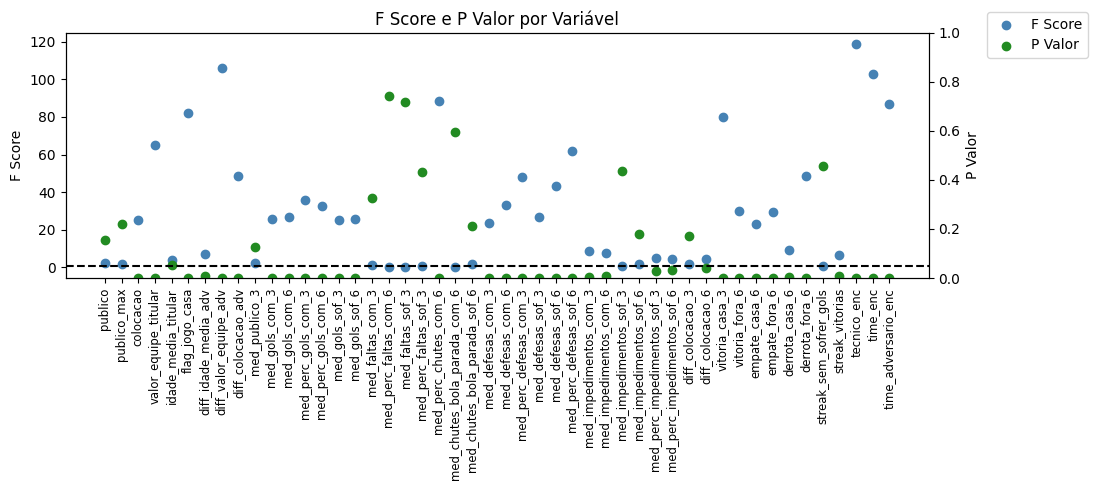

---- Variáveis em Ordem Descrescente de Força ----
tecnico_enc
diff_valor_equipe_adv
time_enc
med_perc_chutes_com_6
time_adversario_enc
flag_jogo_casa
vitoria_casa_3
valor_equipe_titular
med_perc_defesas_sof_6
diff_colocacao_adv
derrota_fora_6
med_perc_defesas_com_3
med_defesas_sof_6
med_perc_gols_com_3
med_defesas_com_6
med_perc_gols_com_6
vitoria_fora_6
empate_fora_6
med_defesas_sof_3
med_gols_com_6
med_gols_sof_6
med_gols_com_3
med_gols_sof_3
colocacao
med_defesas_com_3
empate_casa_6
derrota_casa_6
med_impedimentos_com_3
med_impedimentos_com_6
diff_idade_media_adv
streak_vitorias
med_perc_impedimentos_sof_3
med_perc_impedimentos_sof_6
diff_colocacao_6


In [193]:
# Criar subplots com duplo eixo y
fig, axes1 = plt.subplots(figsize=(10, 5))

# Gráfico superior: Scatter plot F Score por variável
scatter1 = axes1.scatter(df_anova['VAR'], df_anova['F-Score'], color='steelblue', marker='o', label='F Score')
axes1.set_title('F Score e P Valor por Variável')
axes1.set_ylabel('F Score')
axes1.tick_params(axis='x', rotation=90, labelsize='small')

# Criar segundo eixo y para o gráfico superior
axes2 = axes1.twinx()
scatter2 = axes2.scatter(df_anova['VAR'], df_anova['P-Valor'], color='forestgreen', marker='o', label='P Valor')
axes2.set_ylabel('P Valor')
axes2.set_ylim(0,1)

# Adicionar linha horizontal tracejada em P valor 0.05 no gráfico inferior
axes2.axhline(y=0.05, color='black', linestyle='--', label='P Valor = 0.05')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Adicionar legenda combinada
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
fig.legend(scatters, labels, loc='upper right', bbox_to_anchor=(1.10, 0.98))

plt.show()

vars_anova = df_anova[df_anova['P-Valor'] < 0.05].sort_values(by='F-Score', ascending=False)['VAR'].tolist()
df_anova['SEL'] = 0
print('---- Variáveis em Ordem Descrescente de Força ----')
for v in vars_anova:
    df_anova.loc[df_anova['VAR']==v,'SEL'] = 1
    print(v)

#### Model Based
- Selecao Baseada em Modelo - Random Forest

C:\Users\matcg\AppData\Local\Temp\ipykernel_17268\3785735621.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')


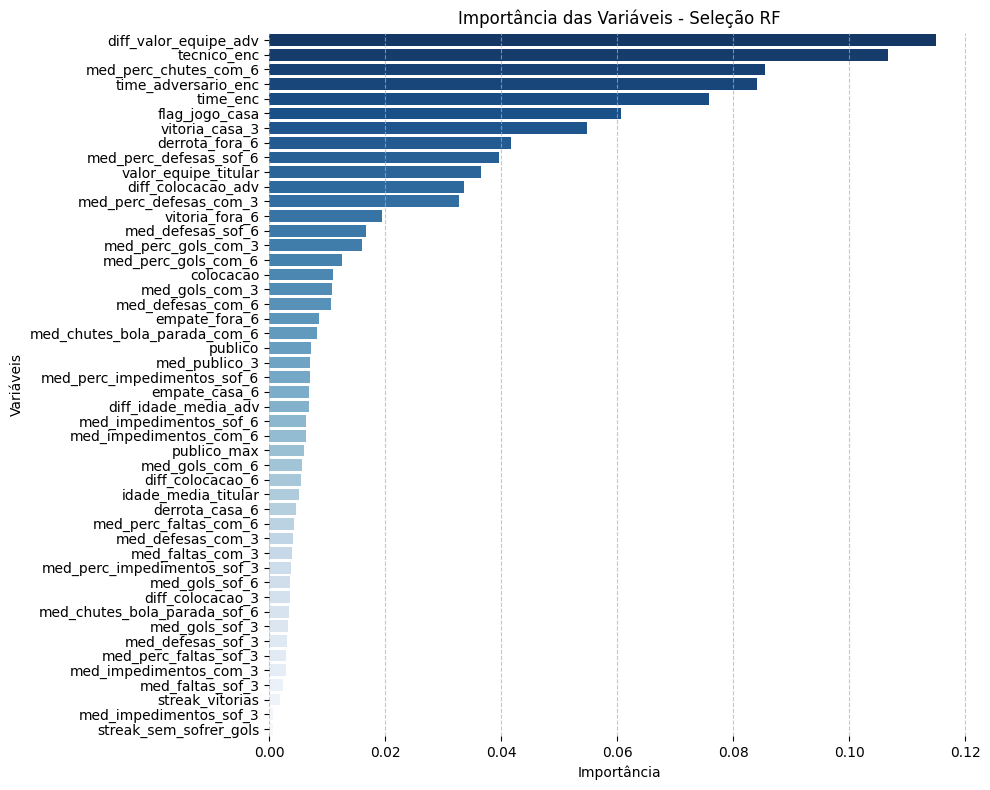

In [194]:
# Crie um modelo de RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Treine o modelo
rf_model.fit(df_filter, y_train)

# Obtenha a importância das características
feature_importances = pd.DataFrame({'VAR': df_filter.columns, 'IMP': rf_model.feature_importances_})

# Crie um gráfico de barras para visualizar a importância das características
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis - Seleção RF')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observa-se claramente que as importâncias estão concentradas nas primeiras 12 variáveis (med_perc_defesas_com_3 pra cima). Assim, podemos adotar um corte na importancia de 0.03

In [195]:
feature_importances['RF_SEL'] = 0
feature_importances.loc[feature_importances['IMP']>0.03, 'RF_SEL'] = 1

Agora, vamos observar como se comporta a precisão de um modelo RF baseline à medida que vamos retirando as variáveis por ordem crescente de importância.
Para este teste, vamos utilizar todas as variáveis.

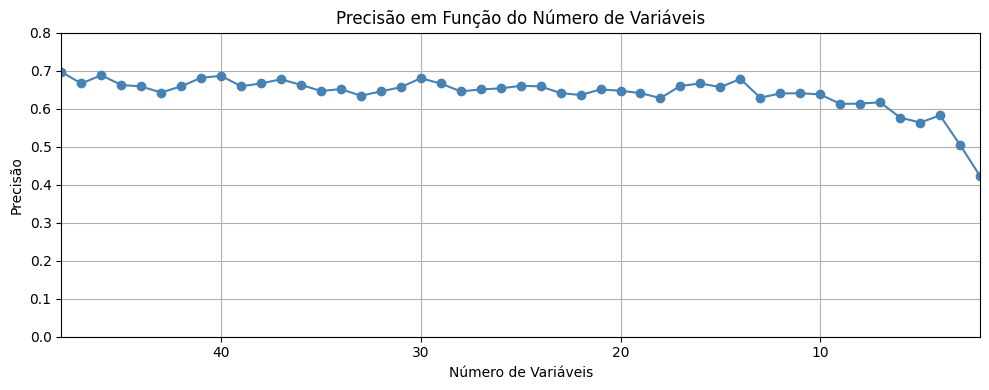

In [196]:
feat_desc = feature_importances.sort_values(by='IMP',ascending=False)['VAR'].to_list()
num_features_list = []
precision_list = []

for i in range(len(feat_desc),1,-1):
    
    selected_features_subset = feat_desc[:i]    
    rf_model.fit(df_filter[selected_features_subset], y_train)    
    y_pred = rf_model.predict(X_sel_test[selected_features_subset])
    
    precision = precision_score(y_test, y_pred)
    num_features_list.append(i)
    precision_list.append(precision)

plt.figure(figsize=(10, 4))
plt.plot(num_features_list, precision_list, marker='o', linestyle='-', color='steelblue')
plt.xlabel('Número de Variáveis')
plt.ylabel('Precisão')
plt.title('Precisão em Função do Número de Variáveis')
plt.grid(True)
plt.xlim(np.max(num_features_list), np.min(num_features_list))
plt.ylim(0, 0.8)
plt.tight_layout()
plt.show()

Nota-se que a partir de 15 variáveis a precisão do Modelo Baseline começa a perder força.

In [197]:
df_compara_sel = pd.merge(df_anova, feature_importances, on='VAR', how='inner')

In [198]:
df_compara_sel

,VAR,F-Score,P-Valor,SEL,IMP,RF_SEL
0,publico,2.009598,1.564669e-01,0,0.007262,0
1,publico_max,1.506066,2.198888e-01,0,0.006076,0
2,colocacao,25.091170,5.962596e-07,1,0.010961,0
3,valor_equipe_titular,65.250074,1.145392e-15,1,0.036461,1
4,idade_media_titular,3.717727,5.398302e-02,0,0.005165,0
5,flag_jogo_casa,82.104202,3.061132e-19,1,0.060586,1
6,diff_idade_media_adv,7.157948,7.525829e-03,1,0.006852,0
7,diff_valor_equipe_adv,106.116062,2.886323e-24,1,0.115044,1
8,diff_colocacao_adv,48.636995,4.204948e-12,1,0.033597,1
9,med_publico_3,2.317064,1.281239e-01,0,0.006998,0


In [199]:
vars_final = df_compara_sel[(df_compara_sel['SEL']==1) & (df_compara_sel['RF_SEL']==1)]['VAR'].to_list()

As variáveis selecionadas com intersecção do método univariado por ANOVA e baseado em modelo por RandomForest são as mesmas 12 que foram selecionadas por RandomForest

In [200]:
vars_final

['valor_equipe_titular',
 'flag_jogo_casa',
 'diff_valor_equipe_adv',
 'diff_colocacao_adv',
 'med_perc_chutes_com_6',
 'med_perc_defesas_com_3',
 'med_perc_defesas_sof_6',
 'vitoria_casa_3',
 'derrota_fora_6',
 'tecnico_enc',
 'time_enc',
 'time_adversario_enc']

Uma vez que temos as variáveis finais, podemos criar um preprocessor final para utilizar de pipeline para dados futuros.

OBS: As variáveis time_enc e time_adversario_enc foram retiradas de forma a evitar overfitting ou ocasionar um viés em relação ao time vs. time adversário. Assim, manteremos apenas o tecnico como variável encoded.

In [201]:
vars_final = ['valor_equipe_titular',
 'flag_jogo_casa',
 'diff_valor_equipe_adv',
 'diff_colocacao_adv',
 'med_perc_chutes_com_6',
 'med_perc_defesas_com_3',
 'med_perc_defesas_sof_6',
 'vitoria_casa_3',
 'derrota_fora_6',
#  'tecnico_enc',
#  'time_enc',
#  'time_adversario_enc'
 ]

num_finais = ['valor_equipe_titular', 'flag_jogo_casa', 'diff_valor_equipe_adv', 'diff_colocacao_adv',
              'med_perc_chutes_com_6', 'med_perc_defesas_com_3', 'med_perc_defesas_sof_6', 'vitoria_casa_3','derrota_fora_6']

# cat_ord_finais = ['tecnico_enc', 
#                   'time_enc', 
#                   'time_adversario_enc'
#                   ]
cat_ord_finais = []


preprocessor_final = cria_pipeline(num_finais, cat_ord_finais)
preprocessor_final.fit(X_train[vars_final])
joblib.dump(preprocessor_final, '../artifacts/preprocessor.pkl')

X_train_f = preprocessor_final.transform(X_train[vars_final])
X_train_f.columns = X_train[vars_final].columns

X_test_f = preprocessor_final.transform(X_test[vars_final])
X_test_f.columns = X_test[vars_final].columns

### Treinamento do Modelo

Para avaliar a performance do Modelo, precisamos treiná-lo utilizando uma métrica de maximização. Podemos escolher a precisão, que mede a proporção de todas as previsões corretas que o modelo fez. Além disso, podemos utilizar uma abordagem de retorno para apostas através da métrica ROI (Return Over Investment)

Sendo assim, vamos combinar a precisão e o ROI na nossa métrica de maximização, adotando pesos para ambos.
Em resumo:

-   O ROI mede a lucratividade financeira, indicando diretamente a capacidade do modelo de gerar retornos sobre o investimento.
-   A precisão é ideal para evitar falsos positivos. Com isso, evitariamos perdas financeiras ao apostar na vitoria de um determinado jogo.

Para cada jogo vamos considerar que será apostado $10 e que para cada ganho, tenha um lucro de 10% sobre o valor apostado

In [202]:
def roi_score(y_true, y_pred_proba, stake_per_bet=10):
    '''
    Calcula o retorno sobre o investimento (ROI)
    '''   

    y_pred = (y_pred_proba >= 0.5).astype(int) # Limiar de 0.5

    total_bets = len(y_true)
    total_wins = sum(y_true * y_pred)

    total_payouts = total_wins * stake_per_bet * 1.1  # Considerando 10% de lucro em vitorias
    total_staked = total_bets * stake_per_bet # Total apostado nao considerando lucros
    net_profit = total_payouts - total_staked
    
    return (net_profit / total_staked)

In [203]:
def cost_sensitive_precision(y_true, y_pred, tp_weight=1, fp_weight=5):
    '''
    Calcula a Precisao com pesos aplicados no TP e FP de 
    forma a penalizar falsos positivos.

    Este método é util quando temos classes desbalanceada. No nosso caso, a taxa de vitoria é 30%
    '''    

    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]  
    fp = cm[0, 1] 

    weighted_tp = -tp_weight*tp
    weighted_fp = -fp_weight*fp    

    cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)

    if np.isnan(cost_sensitive_precision):
        return 0
    else:
        return cost_sensitive_precision

In [204]:
def evaluate_calibration(y_true, y_prob, n_bins=5):
    """
    Calculates calibration metrics.

    Args:
        y_true (array-like): True binary outcomes (0 or 1).
        y_prob (array-like): Predicted probabilities of positive class.
        n_bins (int, optional): Number of bins for calibration curve. Defaults to 5.

        Expected Calibration Error (ECE)
    """

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

        # Calculate ECE
    ece = np.abs(prob_true - prob_pred).mean()

    return ece

In [205]:
# Juntando a variável resposta nos dados de treino 
df_train_f = pd.concat([X_train_f, y_train], axis=1)

In [206]:
df_train_f.shape

(1947, 10)

In [113]:
tscv = TimeSeriesSplit(n_splits=4, max_train_size=800, test_size=300)

# metrics_folds = []    
for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

    print(f'TREINO: {train_index}, TESTE: {test_index}')

TREINO: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 24

In [208]:
def objective(trial, model_name):
    model = None

    model_seed = 42

    if model_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 5),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 300),            
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=model_seed
        )
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga']),
            max_iter=trial.suggest_int('max_iter', 100, 500),
            tol=trial.suggest_float('tol', 1e-4, 1e-2, log=True),                        
            random_state=model_seed
        )
    elif model_name == 'LGBM':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 10, 150),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 200),            
            bagging_fraction=trial.suggest_float('bagging_fraction', 0.01, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            verbose=-1,
            random_state=model_seed
        )
    elif model_name == 'NaiveBayes':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
        )
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
            random_state=model_seed
        )
    elif model_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 20),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2)
        )
    elif model_name == 'SVC':
        model = SVC(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            # kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            kernel=trial.suggest_categorical('kernel', ['linear']),
            gamma=trial.suggest_float('gamma', 1e-3, 1e3, log=True),
            shrinking=trial.suggest_categorical('shrinking', [True, False]), 
            probability=trial.suggest_categorical('probability', [True]),            
            random_state=model_seed
        )
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 6),
            min_samples_split=trial.suggest_int('min_samples_split', 5, 100),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 30),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=model_seed
        )

    # tscv = TimeSeriesSplit(n_splits=5)
    
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=800, test_size=300)

    metrics_folds = []    
    for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

        train = df_train_f.iloc[train_index]
        X_train = train.drop(['vitoria'],axis=1)
        y_train = train['vitoria']
        valid = df_train_f.iloc[test_index]
        X_valid = valid.drop(['vitoria'],axis=1)
        y_valid = valid['vitoria']

        model.fit(X_train, y_train)

        pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]        
        # w_precision = cost_sensitive_precision(y_valid, pred)
        # ece = evaluate_calibration(y_valid, y_pred_proba, 10)
        # roi = roi_score(y_valid, y_pred_proba)        
        # result = 0.8 * w_precision + 0.2 * roi
        # result = roc_auc_score(y_valid, y_pred_proba)
        result = log_loss(y_valid, y_pred_proba)

        metrics_folds.append(result)
               
    return np.mean(metrics_folds)   
    
    # train = df_train_f.iloc[:1363]
    # X_train = train.drop(['vitoria'],axis=1)
    # y_train = train['vitoria']
    # valid = df_train_f.iloc[1363:]
    # X_valid = valid.drop(['vitoria'],axis=1)
    # y_valid = valid['vitoria']

    # model.fit(X_train, y_train)

    # pred = model.predict(X_valid)
    # y_pred_proba = model.predict_proba(X_valid)[:, 1]        
    # # w_precision = cost_sensitive_precision(y_valid, pred)
    # ece = evaluate_calibration(y_valid, y_pred_proba)
    # roi = roi_score(y_valid, y_pred_proba)        
    # # result = 0.8 * w_precision + 0.2 * roi
    # result = 0.8 * (1 - ece) + 0.2 * roi

    # return result


models = ['RandomForest', 'LogisticRegression', 'LGBM', 'NaiveBayes', 'AdaBoostClassifier', 'KNN', 'SVC', 'DecisionTree']

comparison_df = pd.DataFrame(columns=['model', 'best_params', 'best_value'])

for model_name in models:

    print(f'------ {model_name} ------')

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

    best_params = study.best_params
    best_value = round(study.best_value,4)

    df_aux = pd.DataFrame({
        'model': [model_name],
        'best_params': [best_params],
        'best_value': [best_value]
    })

    comparison_df = pd.concat([comparison_df, df_aux],ignore_index=True)

    del df_aux

[I 2024-01-10 20:47:59,362] A new study created in memory with name: no-name-0538835d-3f96-4d08-b88d-dee274519f1f


------ RandomForest ------


[I 2024-01-10 20:48:09,291] Trial 0 finished with value: 0.6204199257072065 and parameters: {'n_estimators': 406, 'max_depth': 5, 'criterion': 'gini', 'min_samples_split': 48, 'min_samples_leaf': 16, 'bootstrap': False}. Best is trial 0 with value: 0.6204199257072065.
[I 2024-01-10 20:48:22,210] Trial 1 finished with value: 0.6159159546617471 and parameters: {'n_estimators': 621, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 250, 'min_samples_leaf': 22, 'bootstrap': False}. Best is trial 1 with value: 0.6159159546617471.
[I 2024-01-10 20:48:29,829] Trial 2 finished with value: 0.6163014352206717 and parameters: {'n_estimators': 339, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 184, 'min_samples_leaf': 14, 'bootstrap': False}. Best is trial 1 with value: 0.6159159546617471.
[I 2024-01-10 20:48:41,680] Trial 3 finished with value: 0.6132518969532703 and parameters: {'n_estimators': 483, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 179, 'min_sam

------ LogisticRegression ------


[I 2024-01-10 20:57:51,990] Trial 3 finished with value: 0.6335074397286904 and parameters: {'C': 0.006870101665590026, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 180, 'tol': 0.0010677482709481358}. Best is trial 1 with value: 0.607735271372193.
[I 2024-01-10 20:57:52,110] Trial 4 finished with value: 0.6048231696983434 and parameters: {'C': 3.584985580340472, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 480, 'tol': 0.00853618986286683}. Best is trial 4 with value: 0.6048231696983434.
[I 2024-01-10 20:57:52,223] Trial 5 finished with value: 0.6077390783887596 and parameters: {'C': 70.85721663941601, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 148, 'tol': 0.0009780337016659412}. Best is trial 4 with value: 0.6048231696983434.
[I 2024-01-10 20:57:52,265] Trial 6 finished with value: 0.6931471805599453 and parameters: {'C': 0.001608166928363465, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 308, 'tol': 0.0012399967836846098}. Best is trial 4 with value: 0.60482316

------ LGBM ------


[I 2024-01-10 20:57:57,261] Trial 0 finished with value: 0.7459257159967594 and parameters: {'n_estimators': 406, 'max_depth': 8, 'learning_rate': 0.0483437145318464, 'num_leaves': 94, 'min_data_in_leaf': 39, 'bagging_fraction': 0.16443457513284063, 'reg_alpha': 0.0014936568554617625, 'reg_lambda': 0.39676050770529875}. Best is trial 0 with value: 0.7459257159967594.
[I 2024-01-10 20:57:57,973] Trial 1 finished with value: 0.627514176472004 and parameters: {'n_estimators': 621, 'max_depth': 6, 'learning_rate': 0.0011152328125494347, 'num_leaves': 146, 'min_data_in_leaf': 168, 'bagging_fraction': 0.2202157195714934, 'reg_alpha': 0.0035113563139704067, 'reg_lambda': 0.0035498788321965025}. Best is trial 1 with value: 0.627514176472004.
[I 2024-01-10 20:57:58,462] Trial 2 finished with value: 0.6190105621484285 and parameters: {'n_estimators': 339, 'max_depth': 5, 'learning_rate': 0.009860942908083906, 'num_leaves': 51, 'min_data_in_leaf': 126, 'bagging_fraction': 0.14809892204552141, 're

------ NaiveBayes ------


[I 2024-01-10 20:58:24,391] Trial 3 finished with value: 0.8870750057934207 and parameters: {'var_smoothing': 9.846738873614562e-07}. Best is trial 1 with value: 0.8867592778719523.
[I 2024-01-10 20:58:24,488] Trial 4 finished with value: 0.8870805567777353 and parameters: {'var_smoothing': 6.02688912868252e-09}. Best is trial 1 with value: 0.8867592778719523.
[I 2024-01-10 20:58:24,554] Trial 5 finished with value: 0.8870805567872263 and parameters: {'var_smoothing': 6.0252157362038635e-09}. Best is trial 1 with value: 0.8867592778719523.
[I 2024-01-10 20:58:24,603] Trial 6 finished with value: 0.8870805798928539 and parameters: {'var_smoothing': 1.9517224641449526e-09}. Best is trial 1 with value: 0.8867592778719523.
[I 2024-01-10 20:58:24,655] Trial 7 finished with value: 0.8869591171504565 and parameters: {'var_smoothing': 2.142302175774106e-05}. Best is trial 1 with value: 0.8867592778719523.
[I 2024-01-10 20:58:24,711] Trial 8 finished with value: 0.8870748455823674 and parameter

------ AdaBoostClassifier ------


[I 2024-01-10 20:58:35,890] Trial 0 finished with value: 0.6908013463449363 and parameters: {'n_estimators': 406, 'learning_rate': 0.36808608148776095}. Best is trial 0 with value: 0.6908013463449363.
[I 2024-01-10 20:58:51,681] Trial 1 finished with value: 0.6862626918623665 and parameters: {'n_estimators': 746, 'learning_rate': 0.04128205343826222}. Best is trial 1 with value: 0.6862626918623665.
[I 2024-01-10 20:58:56,085] Trial 2 finished with value: 0.6299231508303773 and parameters: {'n_estimators': 198, 'learning_rate': 0.0026364803038431655}. Best is trial 2 with value: 0.6299231508303773.
[I 2024-01-10 20:58:58,341] Trial 3 finished with value: 0.6829771853041402 and parameters: {'n_estimators': 105, 'learning_rate': 0.21766241123453672}. Best is trial 2 with value: 0.6299231508303773.
[I 2024-01-10 20:59:12,359] Trial 4 finished with value: 0.6886100162147184 and parameters: {'n_estimators': 621, 'learning_rate': 0.08148293210105287}. Best is trial 2 with value: 0.62992315083

------ KNN ------


[I 2024-01-10 21:04:47,608] Trial 1 finished with value: 1.8779826677559726 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 1.036074220403073.
[I 2024-01-10 21:04:47,843] Trial 2 finished with value: 0.7205821147088206 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.7205821147088206.
[I 2024-01-10 21:04:48,056] Trial 3 finished with value: 0.6318057334365148 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6318057334365148.
[I 2024-01-10 21:04:48,248] Trial 4 finished with value: 1.2130610985658012 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.6318057334365148.
[I 2024-01-10 21:04:48,348] Trial 5 finished with value: 0.6660698031212037 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.6318057334365148.
[I 2024-01-10 21:04:48,553] Trial 6 finished wi

------ SVC ------


[I 2024-01-10 21:04:55,518] Trial 0 finished with value: 0.6368228254938396 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 506.1576888752306, 'shrinking': True, 'probability': True}. Best is trial 0 with value: 0.6368228254938396.
[I 2024-01-10 21:04:55,960] Trial 1 finished with value: 0.634711984172529 and parameters: {'C': 0.008632008168602538, 'kernel': 'linear', 'gamma': 0.008629132190071854, 'shrinking': False, 'probability': True}. Best is trial 1 with value: 0.634711984172529.
[I 2024-01-10 21:04:56,441] Trial 2 finished with value: 0.6222499258070466 and parameters: {'C': 4.0428727350273315, 'kernel': 'linear', 'gamma': 17.71884735480682, 'shrinking': False, 'probability': True}. Best is trial 2 with value: 0.6222499258070466.
[I 2024-01-10 21:04:58,175] Trial 3 finished with value: 0.6168199980245387 and parameters: {'C': 98.77700294007911, 'kernel': 'linear', 'gamma': 0.018794668241638456, 'shrinking': False, 'probability': True}. Best is trial 3 with

------ DecisionTree ------


[I 2024-01-10 21:12:47,667] Trial 2 finished with value: 0.6345036256978906 and parameters: {'max_depth': 1, 'min_samples_split': 98, 'max_leaf_nodes': 26, 'criterion': 'gini'}. Best is trial 1 with value: 0.6333562266635353.
[I 2024-01-10 21:12:47,761] Trial 3 finished with value: 0.6400835115423197 and parameters: {'max_depth': 2, 'min_samples_split': 34, 'max_leaf_nodes': 17, 'criterion': 'gini'}. Best is trial 1 with value: 0.6333562266635353.
[I 2024-01-10 21:12:47,874] Trial 4 finished with value: 0.8364677985537241 and parameters: {'max_depth': 4, 'min_samples_split': 18, 'max_leaf_nodes': 10, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6333562266635353.
[I 2024-01-10 21:12:47,980] Trial 5 finished with value: 1.1072832955476346 and parameters: {'max_depth': 5, 'min_samples_split': 24, 'max_leaf_nodes': 16, 'criterion': 'gini'}. Best is trial 1 with value: 0.6333562266635353.
[I 2024-01-10 21:12:48,071] Trial 6 finished with value: 0.634885485369102 and parameters: {'

In [104]:
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
6,SVC,"{'C': 0.2527809940933973, 'kernel': 'linear', ...",0.17
1,LogisticRegression,"{'C': 0.12099967773941854, 'penalty': 'l2', 's...",0.13
0,RandomForest,"{'n_estimators': 459, 'max_depth': 2, 'criteri...",0.04
2,LGBM,"{'n_estimators': 406, 'max_depth': 6, 'learnin...",0.03
4,AdaBoostClassifier,"{'n_estimators': 307, 'learning_rate': 0.01019...",0.02
5,KNN,"{'n_neighbors': 18, 'weights': 'uniform', 'p': 2}",0.00
7,DecisionTree,"{'max_depth': 4, 'min_samples_split': 84, 'max...",-0.00
3,NaiveBayes,{'var_smoothing': 7.45934328572656e-08},-0.01


In [167]:
# Com walk forward
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
1,LogisticRegression,"{'C': 0.016595183361157326, 'penalty': 'l2', '...",0.20
6,SVC,"{'C': 0.5450293694558254, 'kernel': 'linear', ...",0.19
0,RandomForest,"{'n_estimators': 141, 'max_depth': 5, 'criteri...",0.03
2,LGBM,"{'n_estimators': 61, 'max_depth': 7, 'learning...",0.03
4,AdaBoostClassifier,"{'n_estimators': 137, 'learning_rate': 0.01828...",0.01
5,KNN,"{'n_neighbors': 4, 'weights': 'uniform', 'p': 1}",0.00
3,NaiveBayes,{'var_smoothing': 7.041830285016006e-05},-0.01
7,DecisionTree,"{'max_depth': 3, 'min_samples_split': 59, 'max...",-0.03


In [214]:
# Dados fixos
comparison_df.sort_values(by='best_value',ascending=False)

,model,best_params,best_value
6,SVC,"{'C': 0.24751990713351774, 'kernel': 'linear',...",0.62
1,LogisticRegression,"{'C': 0.012095489763207533, 'penalty': 'l2', '...",0.60
0,RandomForest,"{'n_estimators': 476, 'max_depth': 2, 'criteri...",0.08
4,AdaBoostClassifier,"{'n_estimators': 425, 'learning_rate': 0.00374...",0.08
2,LGBM,"{'n_estimators': 271, 'max_depth': 7, 'learnin...",0.07
5,KNN,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 1}",0.02
3,NaiveBayes,{'var_smoothing': 7.45934328572656e-08},-0.00
7,DecisionTree,"{'max_depth': 5, 'min_samples_split': 34, 'max...",0.00


In [209]:
# Com ECE
comparison_df.sort_values(by='best_value',ascending=True)

,model,best_params,best_value
1,LogisticRegression,"{'C': 1.0039501428777546, 'penalty': 'l2', 'so...",0.6038
0,RandomForest,"{'n_estimators': 990, 'max_depth': 5, 'criteri...",0.6121
2,LGBM,"{'n_estimators': 706, 'max_depth': 7, 'learnin...",0.6159
6,SVC,"{'C': 241.27006809797976, 'kernel': 'linear', ...",0.6167
5,KNN,"{'n_neighbors': 20, 'weights': 'distance', 'p'...",0.6232
4,AdaBoostClassifier,"{'n_estimators': 270, 'learning_rate': 0.00169...",0.6299
7,DecisionTree,"{'max_depth': 1, 'min_samples_split': 10, 'max...",0.6334
3,NaiveBayes,{'var_smoothing': 9.931901475257164e-05},0.8865


In [211]:
comparison_df.iloc[1]['best_params']

{'C': 1.0039501428777546,
 'penalty': 'l2',
 'solver': 'liblinear',
 'max_iter': 277,
 'tol': 0.00019945533231692083}

In [170]:
# AUC
comparison_df.iloc[1]['best_params']

{'C': 1.9315595788530047,
 'penalty': 'l2',
 'solver': 'liblinear',
 'max_iter': 353,
 'tol': 0.0005047116346834324}

In [87]:
comparison_df.iloc[2]['best_params']


{'n_estimators': 134,
 'max_depth': 2,
 'learning_rate': 0.0012707770074499693,
 'num_leaves': 55,
 'min_data_in_leaf': 84,
 'bagging_fraction': 0.27863554145615693,
 'reg_alpha': 0.3063462210622082,
 'reg_lambda': 0.011756010900231853}

O modelo que apresentou desempenho superior após a otimização de seus hiperparâmetros foi o Support Vector Machine (SVM). Agora, procederemos à sua instanciação e avaliação no conjunto de teste.

In [212]:
# model_f = SVC(C=0.2527809940933973,
#               kernel='linear',
#               gamma=17.855441364511133,
#               shrinking=True,
#               probability=True,
#               random_state=42)

# WALK FORWARD
# model_f = LogisticRegression(C=0.016595183361157326,
#               penalty='l2',
#               solver='saga',
#               max_iter=390,
#               tol= 0.000206513740548953,
#               random_state=42)

# DADOS FIXOS
# model_f = SVC(C=0.24751990713351774,
#               kernel='linear',
#               gamma=34.162083356123134,
#               shrinking=True,
#               probability=True,
#               random_state=42)

# Com ECE
# model_f = RandomForestClassifier(n_estimators=207,
#                                  max_depth=5,
#                                  criterion='gini',
#                                  min_samples_split=249,
#                                  min_samples_leaf=14,
#                                  bootstrap= False,
#                                  random_state=42)


# model_f = LGBMClassifier(n_estimators=134,
#                          max_depth=2,
#                          learning_rate=0.0012707770074499693,
#                          num_leaves=55,
#                          min_data_in_leaf=84,
#                          baging_fraction=0.27863554145615693,
#                          reg_alpha=0.3063462210622082,
#                          reg_lambda=0.011756010900231853,
#                          verbose=-1,
#                         random_state=42)

# model_f = SVC(C=0.3831442061540481,
#               kernel='linear',
#               gamma=700.2227655775115,
#               shrinking=True,
#               probability=True,
#               random_state=42)

# Com AUC 
# model_f = LogisticRegression(C=1.9315595788530047,
#               penalty='l2',
#               solver='liblinear',
#               max_iter=353,
#               tol= 0.0005047116346834324,
#               random_state=42)

# Com LOG LOSS
model_f = LogisticRegression(C=1.0039501428777546,
              penalty='l2',
              solver='liblinear',
              max_iter=277,
              tol= 0.00019945533231692083,
              random_state=42)


model_f.fit(X_train_f, y_train)
pred_train = model_f.predict(X_train_f)
pred_f = model_f.predict(X_test_f)

print('--- TREINO ---')
print(f'ROI: {roi_score(y_train, pred_train)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_train, pred_train)}')
print(f'Precisao: {precision_score(y_train, pred_train)}')

print('--- TESTE ---')
print(f'ROI: {roi_score(y_test, pred_f)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_test, pred_f)}')
print(f'Precisao: {precision_score(y_test, pred_f)}')

--- TREINO ---
ROI: -0.8875706214689265
Precisao Penalizada: 0.22639362912400454
Precisao: 0.5940298507462687
--- TESTE ---
ROI: -0.8893413173652694
Precisao Penalizada: 0.30656934306569344
Precisao: 0.6885245901639344


In [ ]:
# AUC
# --- TREINO ---
# ROI: -0.8853107344632768
# Precisao Penalizada: 0.22989807474518686
# Precisao: 0.5988200589970502
# --- TESTE ---
# ROI: -0.8853892215568863
# Precisao Penalizada: 0.29292929292929293
# Precisao: 0.6744186046511628

In [213]:
df_test_f = pd.concat([X_test_f, y_test], axis=1)
df_test_f['pred_vitoria'] = model_f.predict_proba(X_test_f)[:, 1] 

In [181]:
df_test_f['pred_vitoria'].describe()

count    835.000000
mean       0.348961
std        0.142102
min        0.062022
25%        0.232268
50%        0.336278
75%        0.454380
max        0.826588
Name: pred_vitoria, dtype: float64

c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\s

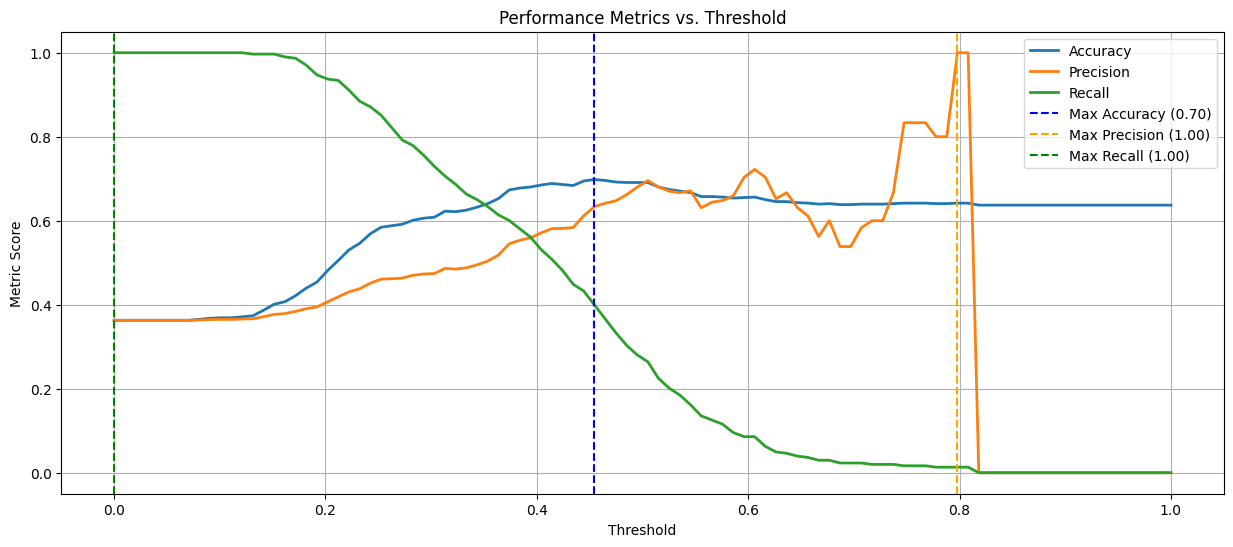

Thresholds that maximize each metric:
- Accuracy: 0.45
- Precision: 0.80
- Recall: 0.00
- F1-score: 0.25


In [235]:
thresholds = np.linspace(0, 1, 100)

y_true = df_test_f['vitoria'].values
preds_prob = df_test_f['pred_vitoria'].values

accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

for threshold in thresholds:
    predicted_labels = (preds_prob >= threshold).astype(int) 

    accuracy = accuracy_score(y_true, predicted_labels)
    precision = precision_score(y_true, predicted_labels)
    recall = recall_score(y_true, predicted_labels)
    f1 = f1_score(y_true, predicted_labels)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

max_accuracy_threshold = thresholds[np.argmax(accuracy_scores)]
max_precision_threshold = thresholds[np.argmax(precision_scores)]
max_recall_threshold = thresholds[np.argmax(recall_scores)]
max_f1_threshold = thresholds[np.argmax(f1_scores)]

plt.figure(figsize=(15, 6))

plt.plot(thresholds, accuracy_scores, linewidth=2, label='Accuracy')
plt.plot(thresholds, precision_scores, linewidth=2, label='Precision')
plt.plot(thresholds, recall_scores, linewidth=2, label='Recall')
# plt.plot(thresholds, f1_scores, linewidth=2, label='F1-Score')

plt.xlabel('Threshold')
plt.ylabel('Metric Score')
plt.title('Performance Metrics vs. Threshold')

plt.axvline(max_accuracy_threshold, color="blue", linestyle="--", label=f"Max Accuracy ({np.max(accuracy_scores):.2f})")
plt.axvline(max_precision_threshold, color="orange", linestyle="--", label=f"Max Precision ({np.max(precision_scores):.2f})")
plt.axvline(max_recall_threshold, color="green", linestyle="--", label=f"Max Recall ({np.max(recall_scores):.2f})")
# plt.axvline(max_f1_threshold, color="red", linestyle="--", label=f"Max F1-score ({np.max(f1_scores):.2f})")

plt.legend()
plt.grid(True)
plt.show()

print(f"Thresholds that maximize each metric:")
print(f"- Accuracy: {max_accuracy_threshold:.2f}")
print(f"- Precision: {max_precision_threshold:.2f}")
print(f"- Recall: {max_recall_threshold:.2f}")
print(f"- F1-score: {max_f1_threshold:.2f}")


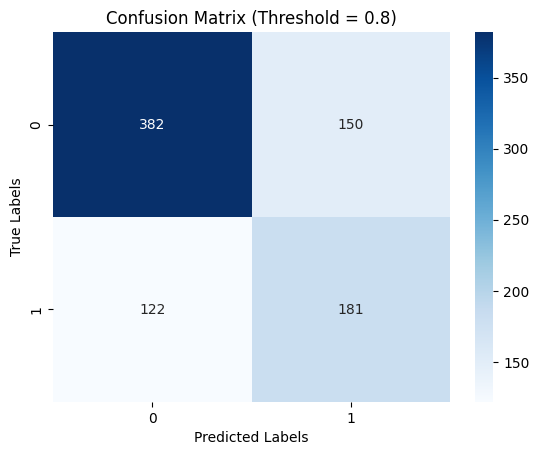

array([[382, 150],
       [122, 181]], dtype=int64)

In [241]:
predicted_labels = (preds_prob >= 0.3762).astype(int) 

cm = confusion_matrix(y_true, predicted_labels)

sns.heatmap(
    cm,
    annot=True,  # Annotate with counts
    cmap="Blues",  # Customize colormap if desired
    fmt="d",  # Display format for annotations (e.g., integers)
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Threshold = 0.8)")

plt.show()

cm

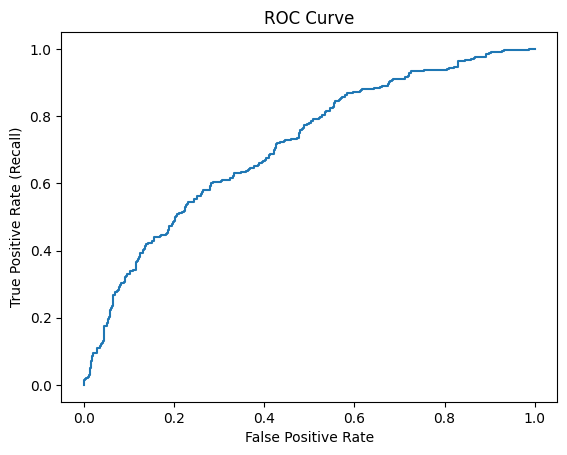

AUC: 0.7112769547631455


In [237]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, preds_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.show()

auc = roc_auc_score(y_true, preds_prob)
print("AUC:", auc)

In [238]:
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

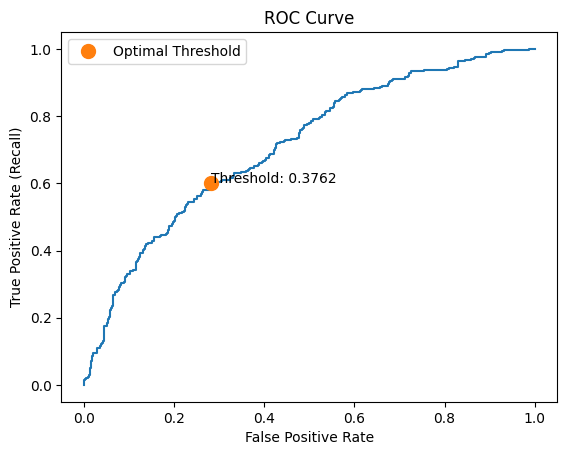

In [240]:
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")

plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', markersize=10, label="Optimal Threshold")
plt.annotate(f"Threshold: {optimal_threshold:.4f}", xy=(fpr[optimal_idx], tpr[optimal_idx]))

plt.legend()
plt.show()

In [232]:
np.unique(y_true, return_counts=True)

(array([0, 1], dtype=int64), array([532, 303], dtype=int64))

In [255]:
# def kelly_criterion(p, b, o, f=1):
#     stake = f * (b * (p * o - 1)) / (o - 1)
#     return stake

# def kelly_criterion(p, b, o, f=1):
#     stake = f * (b * (p * o - 1)) / (o - 1)
#     return stake

# def fixed_percentage(b, percentage=0.05):
#     stake = b * percentage
#     return stake

In [291]:
def kelly_criterion_fraction(probability, odds, fraction=1.0):
    """
    Calculate the Kelly Criterion fraction for optimal bet sizing.

    Parameters:
    - odds: Decimal odds (e.g., 2.0 for even money, 3.0 for 2:1 odds, etc.).
    - probability: Probability of winning (should be between 0 and 1).
    - fraction: Fraction of the current bankroll to consider (default is 1.0).

    Returns:
    - The fraction of the current bankroll to bet according to the Kelly Criterion.
    """
    b = odds - 1  # Net odds received on the bet
    q = 1 - probability
    kelly = (b * probability - q) / b

    # Ensure the fraction is within the specified limits
    kelly_fraction = fraction*kelly

    return kelly_fraction

In [327]:
df_test

,ano_campeonato,rodada,publico,publico_max,colocacao,valor_equipe_titular,idade_media_titular,vitoria,flag_jogo_casa,diff_idade_media_adv,...,vitoria_fora_6,empate_casa_6,empate_fora_6,derrota_casa_6,derrota_fora_6,streak_sem_sofrer_gols,streak_vitorias,tecnico_enc,time_enc,time_adversario_enc
0,2022,23,24029.0,82238.0,18.0,4900000.0,26.6,0,0,-1.3,...,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.339921,0.239618,0.304053
1,2022,23,12598.0,20120.0,10.0,40400000.0,26.6,1,1,-2.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.266685,0.341436,0.257324
2,2022,23,2488.0,13212.0,14.0,11250000.0,29.7,0,0,4.0,...,1.0,0.0,3.0,0.0,2.0,0.0,0.0,NaN,0.310497,0.300320
3,2022,23,15023.0,42372.0,5.0,36400000.0,27.0,0,1,-3.6,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.441277,0.393830,0.341067
4,2022,23,3095.0,23726.0,20.0,6900000.0,28.9,0,1,-0.4,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.216097,0.250481,0.493338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2023,26,40800.0,49205.0,14.0,4440.0,28.4,0,1,0.6,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.351780,0.393830,0.257324
831,2023,26,45193.0,82238.0,7.0,4610.0,30.9,0,1,0.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.424476,0.440126,0.493338
832,2023,26,15388.0,42372.0,8.0,3160.0,26.2,0,1,0.2,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.412149,0.393830,0.300320
833,2023,26,23830.0,60326.0,6.0,1165.0,30.6,1,1,0.8,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.379052,0.341436,0.341067


[0, 0, 0, 145.31447424580145, 0, 313.0589944305752, 471.12389594922104, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 29.298212071066217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 200.36508512604786, 69.48672782244259, 0, 0, 0, 577.568403709162, 0, 4.319378045686656, 0, 0, 0, 0, 0, 0, 5.244388686948766, 0, 0, 0, 0, 0, 0.14675176583421257, 0, 0, 0, 125.0012466752005, 0, 0, 0, 0, 0, 0, 3.177281392267227, 343.6712040280423, 0, 0, 0, 0, 0, 0, 0, 192.97193942906276, 239.62896038711872, 0, 0, 0, 408.69715247274564, 0, 67.04235510867798, 27.480968893403585, 0, 0, 0, 0, 185.07131589296174, 0, 0, 0, 0, 0, 100.04546782148165, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73.83065631114764, 106.36900745196111, 160.54980259251178, 0, 0, 17.228074164987536, 0, 0, 65.96526959100905, 0, 0, 0, 0, 0, 0, 0, 99.71018599647816, 0, 0, 354.1201563990542, 439.5320599046974, 0, 0, 0, 0, 0, 0, 209.13420803270435, 0, 0, 772.9293079483587, 0, 0, 0, 0, 0, 0, 595.9488860527666, 0, 0, 0, 0, 0, 0, 0, 0, 352.0479571596

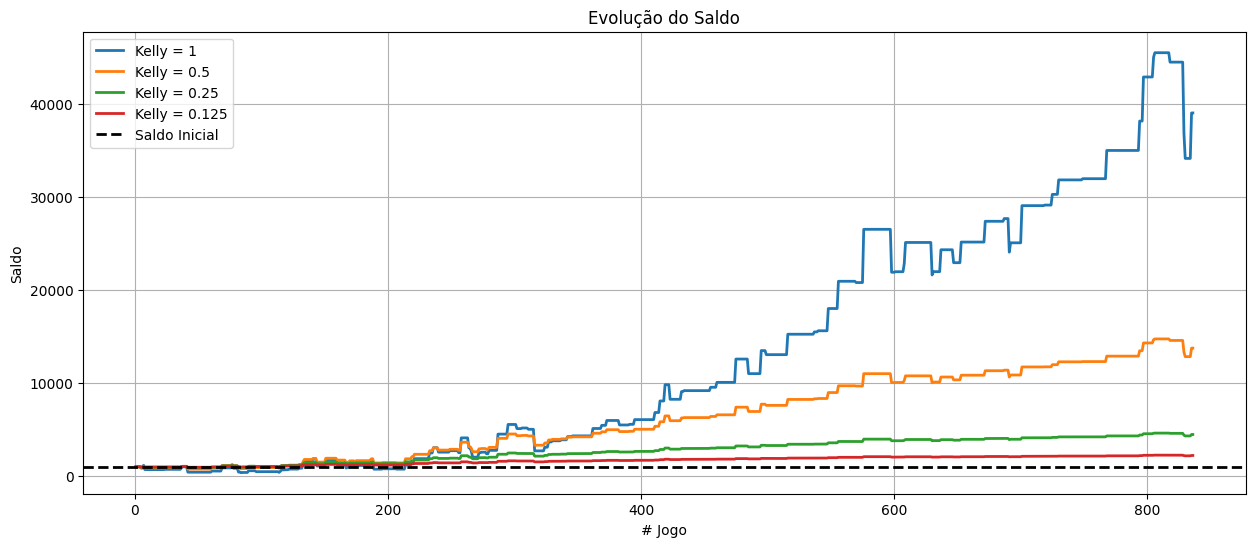

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,116262.812019,14.593301,68.852459,1.000,39028.717616,3802.871762
1,35702.892846,14.593301,68.852459,0.500,13755.758352,1275.575835
2,9804.599571,14.593301,68.852459,0.250,4471.185209,347.118521
3,3512.049016,14.593301,68.852459,0.125,2216.632570,121.663257


In [326]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
odds = 2.0
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros = [], [], []    
    for prob, outcome in zip(preds_prob, y_true): 
        
        f_star = kelly_criterion_fraction(prob, 2, k)
        stake = f_star*bankroll

        if stake < 0:
            stake = 0

        if outcome == 1:
            # winning = 1
            win_value = stake * (odds - 1)
            lucros.append(win_value)
            bankroll += win_value
        else:
            # winning = 0
            bankroll -= stake
            lucros.append(-stake)
        
        aposta_ganha = (1 if stake*outcome>0 else 0)
        
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    print(stakes)
    print(f'Lucro total: {np.sum(lucros)}')
    valor_total_apostado = np.sum(stakes)   
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({'total_apostado': [valor_total_apostado],
                        '%_jogos_apostados': [qtd_jogos_apostados/len(bankroll_history)*100],
                        '%_apostas_ganhas': [qtd_apostas_ganhas/qtd_jogos_apostados*100],
                        'fracao_kelly': [k],
                        'saldo_final': [bankroll_history[-1]],
                        '%_roi': [roi]
    })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

# Print results
# print(f"Bankroll final: {bankroll:.2f}")
# print(f"Bankroll history: {bankroll_history}")
# print(f"Total ROI: {roi:.2f} %")
# print(f"Total ROI 2 : {roi2:.2f} %")
# print(f"Bets: {stakes}")
# print(f"Winnings: {winnings}")

# Customize plot
plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

In [316]:
a = (1 if 0*5>0 else 0)
a

0

In [ ]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
stakes, winnings, aposta_ganha, dfs_resumo = [], [], [], []
odds = 2.0

bankroll = 1000 
bankroll_history = [bankroll]

plt.figure(figsize=(15, 6)) # Cria a figura
plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    for prob, outcome in zip(preds_prob, y_true): 
        
        f_star = kelly_criterion_fraction(prob, 2, k)
        stake = f_star*bankroll

        if stake < 0:            
            stake = 0

        if outcome == 1:
            winning = 1
            win_value = stake * (odds - 1)
            bankroll += win_value
        else:
            winning = 0
            bankroll -= stake
        
        stakes.append(stake)
        winnings.append(winning)
        bankroll_history.append(bankroll)

    valor_total_apostado = sum(stakes)   
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
    qtd_apostas_ganhas = np.sum(winnings)

    df_k = pd.DataFrame({'%_jogos_apostados': [qtd_jogos_apostados/len(bankroll_history)*100],
                        '%_apostas_ganhas': [qtd_apostas_ganhas/qtd_jogos_apostados*100],
                        'fracao_kelly': [k],
                        'saldo_final': [bankroll_history[-1]],
                        '%_roi': [roi]
    })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

# Print results
# print(f"Bankroll final: {bankroll:.2f}")
# print(f"Bankroll history: {bankroll_history}")
# print(f"Total ROI: {roi:.2f} %")
# print(f"Total ROI 2 : {roi2:.2f} %")
# print(f"Bets: {stakes}")
# print(f"Winnings: {winnings}")

# Customize plot
plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

In [302]:
np.sum([1 if s>0 else 0 for s in stakes])

122